In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from nilearn.image import math_img
from nistats.second_level_model import SecondLevelModel
from nistats.design_matrix import make_second_level_design_matrix
from nistats.reporting import plot_design_matrix, get_clusters_table
from nistats.thresholding import map_threshold
from nilearn import plotting

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

/usr/lib/python3/dist-packages/ipykernel_launcher.py:8: FutureWarning: 

 | Starting with Nilearn 0.7.0, all Nistats functionality has been incorporated into Nilearn's stats & reporting modules.
 | Nistats package will no longer be updated or maintained.

  
/home/lussier/.local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


Statistical comparisons of R2 maps 
=========================================================

In [2]:
#Load the R2 maps generated from the previously run dypac embeddings model.
path_base = '/home/lussier/Projects/'
r2_path = 'data/ccna/r2maps500_20/'
r2maps = []
r2_file = open((os.path.join(path_base,r2_path, 'ccna_r2maps.txt')),'r')
for line in r2_file:
    r2maps.append(os.path.join(path_base,r2_path, (line.strip())))
r2_file.close()
print(r2maps)

['/home/lussier/Projects/data/ccna/r2maps500_20/sub_0.nii.gz', '/home/lussier/Projects/data/ccna/r2maps500_20/sub_1.nii.gz', '/home/lussier/Projects/data/ccna/r2maps500_20/sub_2.nii.gz', '/home/lussier/Projects/data/ccna/r2maps500_20/sub_3.nii.gz', '/home/lussier/Projects/data/ccna/r2maps500_20/sub_4.nii.gz', '/home/lussier/Projects/data/ccna/r2maps500_20/sub_5.nii.gz', '/home/lussier/Projects/data/ccna/r2maps500_20/sub_6.nii.gz', '/home/lussier/Projects/data/ccna/r2maps500_20/sub_7.nii.gz', '/home/lussier/Projects/data/ccna/r2maps500_20/sub_8.nii.gz', '/home/lussier/Projects/data/ccna/r2maps500_20/sub_9.nii.gz', '/home/lussier/Projects/data/ccna/r2maps500_20/sub_10.nii.gz', '/home/lussier/Projects/data/ccna/r2maps500_20/sub_11.nii.gz', '/home/lussier/Projects/data/ccna/r2maps500_20/sub_12.nii.gz', '/home/lussier/Projects/data/ccna/r2maps500_20/sub_13.nii.gz', '/home/lussier/Projects/data/ccna/r2maps500_20/sub_14.nii.gz', '/home/lussier/Projects/data/ccna/r2maps500_20/sub_15.nii.gz', '

In [3]:
# Load the .csv with the phenotypic data 
behavioral = pd.read_csv('/home/lussier/Projects/embeddings/ccna/ccna_pheno.csv', header = 0, sep=',')
for row in behavioral:
    print(row)

FILEID
SUBJECTID
Sex
SEX_RECODE
SITEID
SITE_RECODE
group
DX_GROUP_RECODE
AGE_AT_SCAN


In [4]:
#Load the file id from the csv
file_id = behavioral['FILEID'].values
print(file_id)

['sub_0.nii.gz' 'sub_1.nii.gz' 'sub_2.nii.gz' 'sub_3.nii.gz'
 'sub_4.nii.gz' 'sub_5.nii.gz' 'sub_6.nii.gz' 'sub_7.nii.gz'
 'sub_8.nii.gz' 'sub_9.nii.gz' 'sub_10.nii.gz' 'sub_11.nii.gz'
 'sub_12.nii.gz' 'sub_13.nii.gz' 'sub_14.nii.gz' 'sub_15.nii.gz'
 'sub_16.nii.gz' 'sub_17.nii.gz' 'sub_18.nii.gz' 'sub_19.nii.gz'
 'sub_20.nii.gz' 'sub_21.nii.gz' 'sub_22.nii.gz' 'sub_23.nii.gz'
 'sub_24.nii.gz' 'sub_25.nii.gz' 'sub_26.nii.gz' 'sub_27.nii.gz'
 'sub_28.nii.gz' 'sub_29.nii.gz' 'sub_30.nii.gz' 'sub_31.nii.gz'
 'sub_32.nii.gz' 'sub_33.nii.gz' 'sub_34.nii.gz' 'sub_35.nii.gz'
 'sub_36.nii.gz' 'sub_37.nii.gz' 'sub_38.nii.gz' 'sub_40.nii.gz'
 'sub_41.nii.gz' 'sub_42.nii.gz' 'sub_43.nii.gz' 'sub_44.nii.gz'
 'sub_45.nii.gz' 'sub_46.nii.gz' 'sub_47.nii.gz' 'sub_48.nii.gz'
 'sub_49.nii.gz' 'sub_50.nii.gz' 'sub_51.nii.gz' 'sub_52.nii.gz'
 'sub_53.nii.gz' 'sub_54.nii.gz' 'sub_55.nii.gz' 'sub_56.nii.gz'
 'sub_57.nii.gz' 'sub_58.nii.gz' 'sub_59.nii.gz' 'sub_60.nii.gz'
 'sub_61.nii.gz' 'sub_62.nii.gz' 's

In [5]:
#Load the condition of interest by header name
#The conditions must be recoded numeric values and not strings
conditions = behavioral['DX_GROUP_RECODE'].values
print(conditions)

[ 0  0  1  1  1  1  2  1  7  9  1  8  1  1  1  1  1  1  0  5  2  0  2  1
  6  1  1  3  1  1  1  2  8  7  6  2  2  1  0  1  6  1  1  1  2  1  2  1
  2  0  1  1  0  1  7  2  1  1  4  0  1  2  4  0  1  1  4  2  1  7  2  1
  3  0  0  3  1  0  1  1  1  1  2  1  9  4  0  1  2  1  9  1  0  1  3  1
  3  1  3  4  2  9  9  1  7  2  1  3  2  2  1  0  3  1  0  1  2  4  2  1
  2  0  3  2  1  2 10  1  2  1  2  5  5  2  1  3  7  2  1]


Build a design matrix
==================

In [6]:
confounds = pd.DataFrame({'subject_label': file_id,
                          'conditions': conditions,
                          'sex': behavioral['SEX_RECODE'],
                          'age': behavioral['AGE_AT_SCAN'],
                          'site': behavioral['SITE_RECODE']
                         })
print(confounds)

      subject_label  conditions  sex    age  site
0      sub_0.nii.gz           0    0  81.79     0
1      sub_1.nii.gz           0    0  71.93     1
2      sub_2.nii.gz           1    1  71.98     2
3      sub_3.nii.gz           1    1  76.32     1
4      sub_4.nii.gz           1    1  74.23     1
..              ...         ...  ...    ...   ...
134  sub_136.nii.gz           1    0  75.31     4
135  sub_137.nii.gz           3    0  63.35     8
136  sub_138.nii.gz           7    0  79.92    12
137  sub_139.nii.gz           2    1  61.25     3
138  sub_140.nii.gz           1    1  70.30     3

[139 rows x 5 columns]


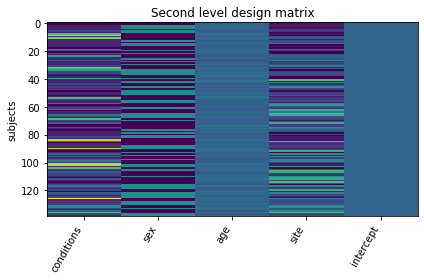

In [7]:
design_matrix = make_second_level_design_matrix(file_id, confounds)

ax = plot_design_matrix(design_matrix)
ax.set_title('Second level design matrix', fontsize=12)
ax.set_ylabel('subjects')
plt.tight_layout()
plt.show()

Second level model estimation
===========================================

In [8]:
second_level_input = r2maps
second_level_model = SecondLevelModel().fit(
        second_level_input, design_matrix=design_matrix)

Contrasts for sex
==========
Here we contrast the embedding for women versus men.

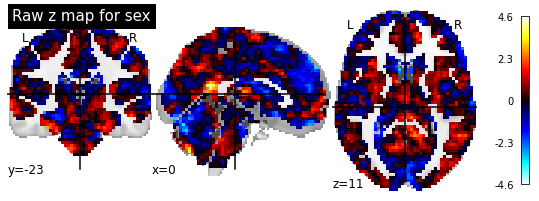

In [9]:
zmap_sex = second_level_model.compute_contrast(
    'sex', output_type='z_score')
plotting.plot_stat_map(zmap_sex, title='Raw z map for sex')
plotting.show()

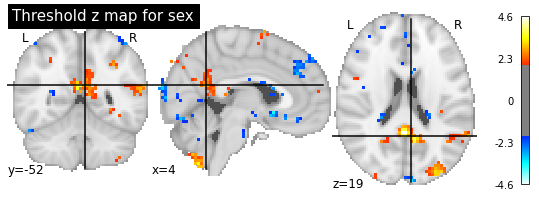

In [10]:
plotting.plot_stat_map(zmap_sex, threshold=2, title='Threshold z map for sex')
plotting.show()

FDR, p<0.05 threshold: inf


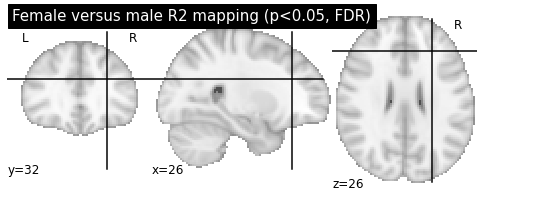

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)


In [11]:
_, threshold = map_threshold(zmap_sex, alpha=.05, height_control='fdr')
print('FDR, p<0.05 threshold: %.3f' % threshold)
plotting.plot_stat_map(zmap_sex, threshold=threshold, 
              title='Female versus male R2 mapping (p<0.05, FDR)')
plt.show()

get_clusters_table(zmap_sex, stat_threshold=threshold, cluster_threshold=None)

Regression for age
==========
Here we conduct a regression to investigate the effect of age on the embeddings.

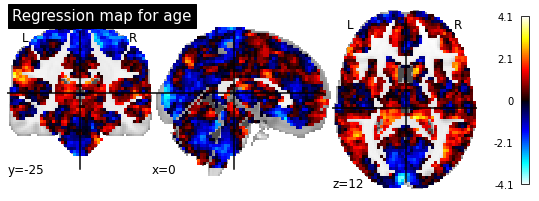

In [12]:
from nistats.regression import OLSModel, SimpleRegressionResults

age = behavioral['AGE_AT_SCAN']

regression_model = OLSModel(design_matrix).fit(age)
regression_result = SimpleRegressionResults(regression_model)

#contrast_age = SimpleRegressionResults.Fcontrast(design_matrix)
contrast_age = second_level_model.compute_contrast(
    'age', regression_result, output_type='z_score')

plotting.plot_stat_map(contrast_age, title='Regression map for age')
plotting.show()

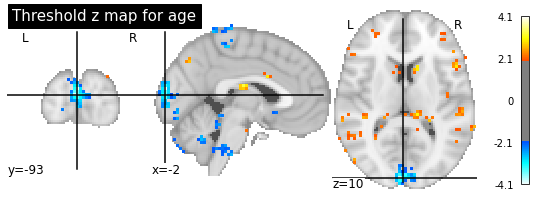

In [13]:
plotting.plot_stat_map(contrast_age, threshold=2, title='Threshold z map for age')
plotting.show()

FDR, p<0.05 threshold: inf


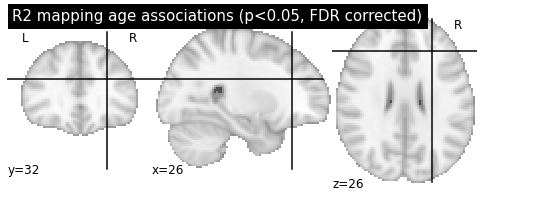

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)


In [14]:
_, threshold = map_threshold(contrast_age, alpha=.05, height_control='fdr')
print('FDR, p<0.05 threshold: %.3f' % threshold)
plotting.plot_stat_map(contrast_age, threshold=threshold, 
              title='R2 mapping age associations (p<0.05, FDR corrected)')
plt.show()

get_clusters_table(contrast_age, stat_threshold=threshold, cluster_threshold=None)

Comparisons of individual diagnoses 
=============
Now we compare embedding quality of specific conditions, namely AD, MCI, SCI, and PD, where n >= 10 in the sample.

AD versus MCI
=====

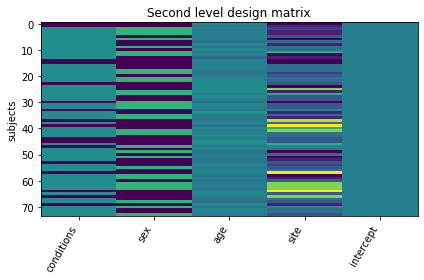

In [15]:
path_base = '/home/lussier/Projects/'
r2_path = 'data/ccna/r2maps500_20/'

r2maps_admci = []
r2_file_admci = open((os.path.join(path_base,r2_path, 'ccna_r2maps_admci.txt')),'r')
for line in r2_file_admci:
    r2maps_admci.append(os.path.join(path_base,r2_path, (line.strip())))
r2_file_admci.close()

behavioral_admci = pd.read_csv('/home/lussier/Projects/embeddings/ccna/ccna_pheno_admci.csv', header = 0, sep=',')

file_id = behavioral_admci['FILEID'].values
conditions = behavioral_admci['DX_GROUP_RECODE'].values

confounds = pd.DataFrame({'subject_label': file_id,
                          'conditions': conditions,
                          'sex': behavioral_admci['SEX_RECODE'],
                          'age': behavioral_admci['AGE_AT_SCAN'],
                          'site': behavioral_admci['SITE_RECODE']
                         })

design_matrix = make_second_level_design_matrix(file_id, confounds)

ax = plot_design_matrix(design_matrix)
ax.set_title('Second level design matrix', fontsize=12)
ax.set_ylabel('subjects')
plt.tight_layout()
plt.show()

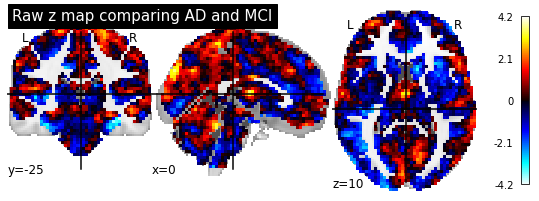

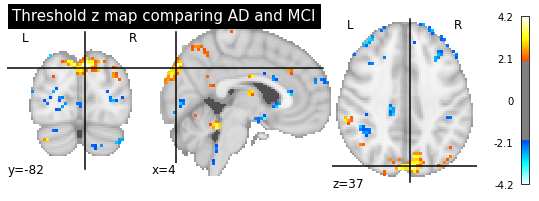

In [16]:
second_level_input = r2maps_admci
second_level_model = SecondLevelModel().fit(
        second_level_input, design_matrix=design_matrix)

zmap_admci = second_level_model.compute_contrast(
    'conditions', output_type='z_score')
plotting.plot_stat_map(zmap_admci, title='Raw z map comparing AD and MCI')
plotting.show()

plotting.plot_stat_map(zmap_admci, threshold=2, title='Threshold z map comparing AD and MCI')
plotting.show()

FDR, p<0.05 threshold: inf


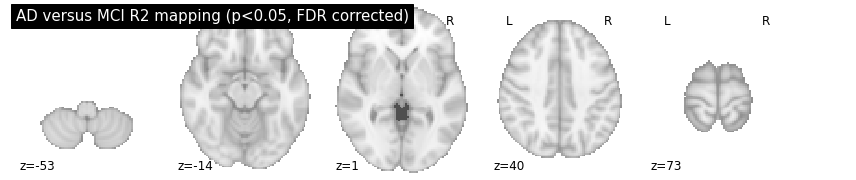

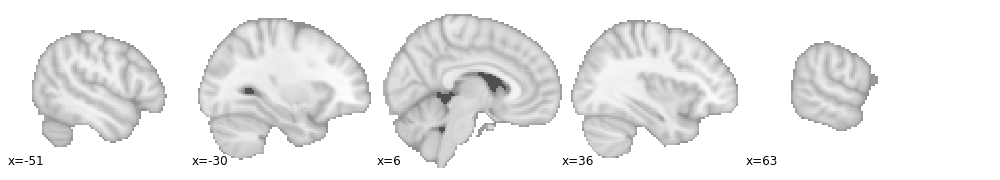

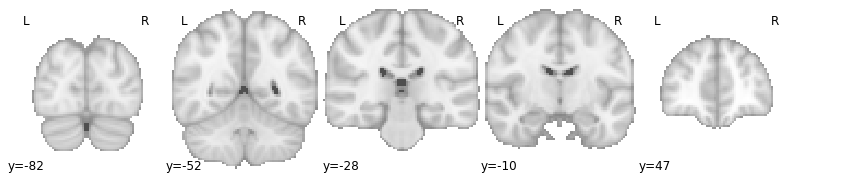

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)


In [17]:
_, threshold = map_threshold(zmap_admci, alpha=.05, height_control='fdr')
print('FDR, p<0.05 threshold: %.3f' % threshold)
plotting.plot_stat_map(zmap_admci, threshold=threshold, display_mode='z', cut_coords=5,
              title='AD versus MCI R2 mapping (p<0.05, FDR corrected)')
plt.show()

plotting.plot_stat_map(zmap_admci, threshold=threshold, display_mode='x', cut_coords=5)
plt.show()

plotting.plot_stat_map(zmap_admci, threshold=threshold, display_mode='y', cut_coords=5)
plt.show()

get_clusters_table(zmap_admci, stat_threshold=threshold, cluster_threshold=None)

AD versus SCI
=====

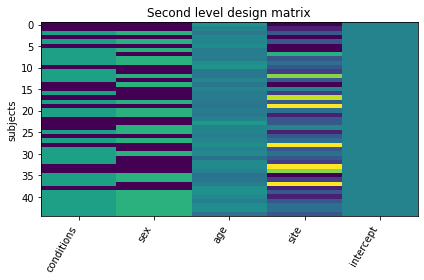

In [18]:
r2maps_adsci = []
r2_file_adsci = open((os.path.join(path_base,r2_path, 'ccna_r2maps_adsci.txt')),'r')
for line in r2_file_adsci:
    r2maps_adsci.append(os.path.join(path_base,r2_path, (line.strip())))
r2_file_adsci.close()

behavioral_adsci = pd.read_csv('/home/lussier/Projects/embeddings/ccna/ccna_pheno_adsci.csv', header = 0, sep=',')

file_id = behavioral_adsci['FILEID'].values
conditions = behavioral_adsci['DX_GROUP_RECODE'].values

confounds = pd.DataFrame({'subject_label': file_id,
                          'conditions': conditions,
                          'sex': behavioral_adsci['SEX_RECODE'],
                          'age': behavioral_adsci['AGE_AT_SCAN'],
                          'site': behavioral_adsci['SITE_RECODE']
                         })

design_matrix = make_second_level_design_matrix(file_id, confounds)

ax = plot_design_matrix(design_matrix)
ax.set_title('Second level design matrix', fontsize=12)
ax.set_ylabel('subjects')
plt.tight_layout()
plt.show()

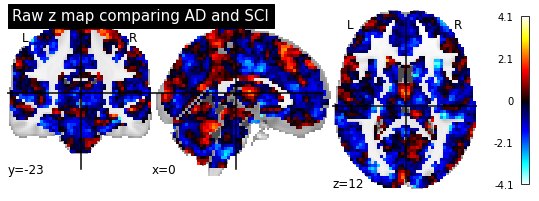

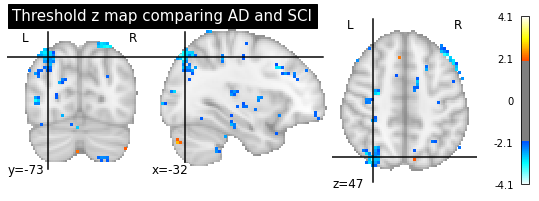

In [19]:
second_level_input = r2maps_adsci
second_level_model = SecondLevelModel().fit(
        second_level_input, design_matrix=design_matrix)

zmap_adsci = second_level_model.compute_contrast(
    'conditions', output_type='z_score')
plotting.plot_stat_map(zmap_adsci, title='Raw z map comparing AD and SCI')
plotting.show()

plotting.plot_stat_map(zmap_adsci, threshold=2, title='Threshold z map comparing AD and SCI')
plotting.show()

FDR, p<0.05 threshold: inf


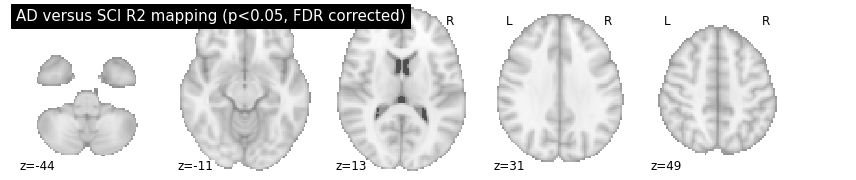

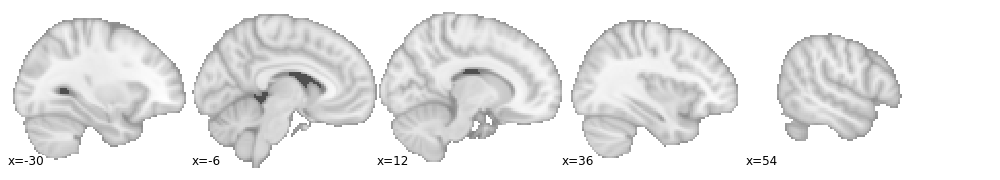

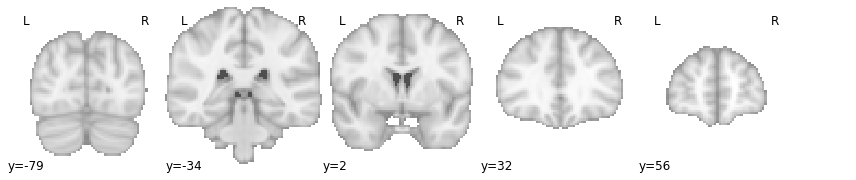

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)


In [20]:
_, threshold = map_threshold(zmap_adsci, alpha=.05, height_control='fdr')
print('FDR, p<0.05 threshold: %.3f' % threshold)
plotting.plot_stat_map(zmap_adsci, threshold=threshold, display_mode='z', cut_coords=5,
              title='AD versus SCI R2 mapping (p<0.05, FDR corrected)')
plt.show()

plotting.plot_stat_map(zmap_adsci, threshold=threshold, display_mode='x', cut_coords=5)
plt.show()

plotting.plot_stat_map(zmap_adsci, threshold=threshold, display_mode='y', cut_coords=5)
plt.show()

get_clusters_table(zmap_adsci, stat_threshold=threshold, cluster_threshold=None)

AD versus PD
=====

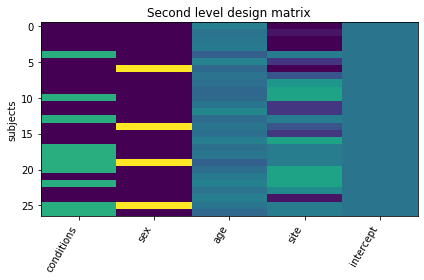

In [21]:
r2maps_adpd = []
r2_file_adpd = open((os.path.join(path_base,r2_path, 'ccna_r2maps_adpd.txt')),'r')
for line in r2_file_adpd:
    r2maps_adpd.append(os.path.join(path_base,r2_path, (line.strip())))
r2_file_adpd.close()

behavioral_adpd = pd.read_csv('/home/lussier/Projects/embeddings/ccna/ccna_pheno_adpd.csv', header = 0, sep=',')

file_id = behavioral_adpd['FILEID'].values
conditions = behavioral_adpd['DX_GROUP_RECODE'].values

confounds = pd.DataFrame({'subject_label': file_id,
                          'conditions': conditions,
                          'sex': behavioral_adpd['SEX_RECODE'],
                          'age': behavioral_adpd['AGE_AT_SCAN'],
                          'site': behavioral_adpd['SITE_RECODE']
                         })

design_matrix = make_second_level_design_matrix(file_id, confounds)

ax = plot_design_matrix(design_matrix)
ax.set_title('Second level design matrix', fontsize=12)
ax.set_ylabel('subjects')
plt.tight_layout()
plt.show()

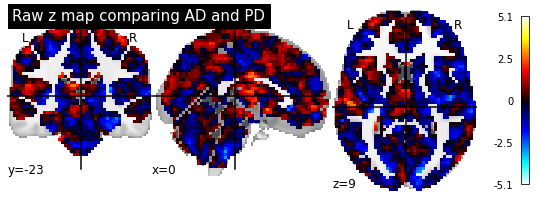

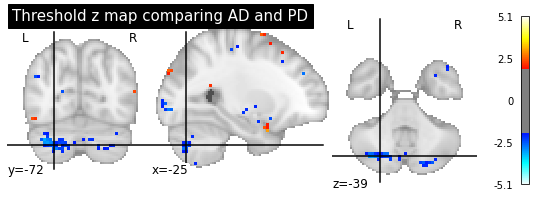

In [22]:
second_level_input = r2maps_adpd
second_level_model = SecondLevelModel().fit(
        second_level_input, design_matrix=design_matrix)

zmap_adpd = second_level_model.compute_contrast(
    'conditions', output_type='z_score')
plotting.plot_stat_map(zmap_adpd, title='Raw z map comparing AD and PD')
plotting.show()

plotting.plot_stat_map(zmap_adpd, threshold=2, title='Threshold z map comparing AD and PD')
plotting.show()

FDR, p<0.05 threshold: 5.058


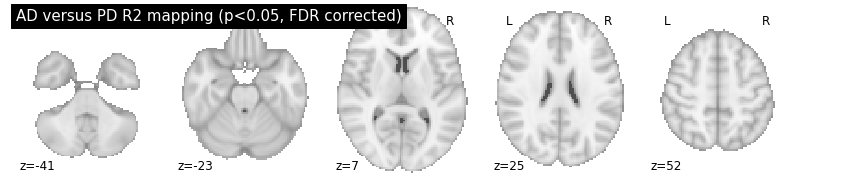

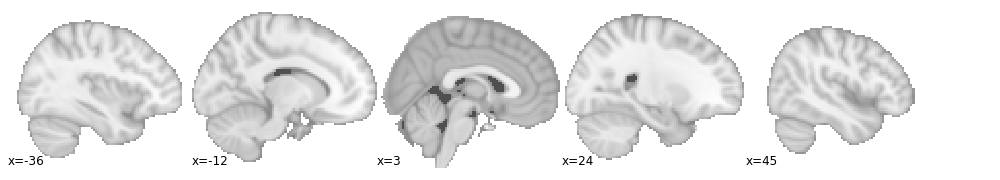

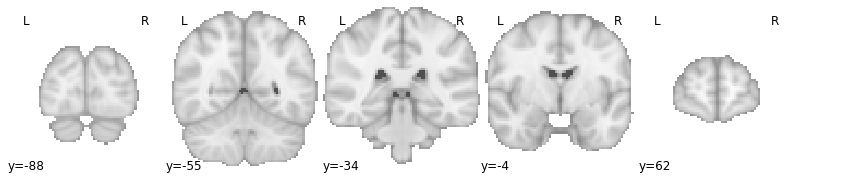

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)
0,1,-36.0,-88.0,25.0,5.057805,27


In [23]:
_, threshold = map_threshold(zmap_adpd, alpha=.05, height_control='fdr')
print('FDR, p<0.05 threshold: %.3f' % threshold)
plotting.plot_stat_map(zmap_adpd, threshold=threshold, display_mode='z', cut_coords=5,
              title='AD versus PD R2 mapping (p<0.05, FDR corrected)')
plt.show()

plotting.plot_stat_map(zmap_adpd, threshold=threshold, display_mode='x', cut_coords=5)
plt.show()

plotting.plot_stat_map(zmap_adpd, threshold=threshold, display_mode='y', cut_coords=5)
plt.show()

get_clusters_table(zmap_adpd, stat_threshold=threshold, cluster_threshold=None)

MCI versus SCI
====

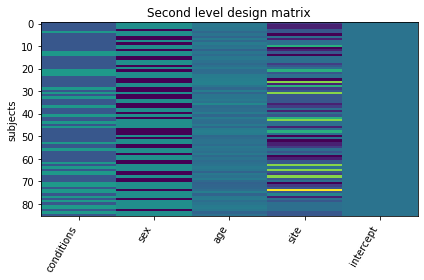

In [24]:
r2maps_mcisci = []
r2_file_mcisci = open((os.path.join(path_base,r2_path, 'ccna_r2maps_mcisci.txt')),'r')
for line in r2_file_mcisci:
    r2maps_mcisci.append(os.path.join(path_base,r2_path, (line.strip())))
r2_file_mcisci.close()

behavioral_mcisci = pd.read_csv('/home/lussier/Projects/embeddings/ccna/ccna_pheno_mcisci.csv', header = 0, sep=',')

file_id = behavioral_mcisci['FILEID'].values
conditions = behavioral_mcisci['DX_GROUP_RECODE'].values

confounds = pd.DataFrame({'subject_label': file_id,
                          'conditions': conditions,
                          'sex': behavioral_mcisci['SEX_RECODE'],
                          'age': behavioral_mcisci['AGE_AT_SCAN'],
                          'site': behavioral_mcisci['SITE_RECODE']
                         })

design_matrix = make_second_level_design_matrix(file_id, confounds)

ax = plot_design_matrix(design_matrix)
ax.set_title('Second level design matrix', fontsize=12)
ax.set_ylabel('subjects')
plt.tight_layout()
plt.show()

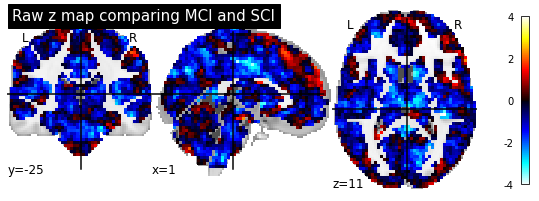

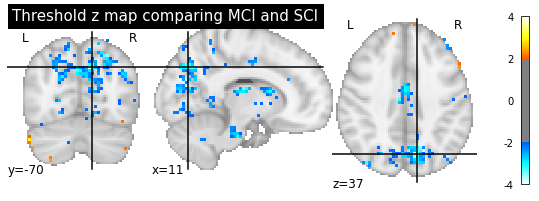

In [25]:
second_level_input = r2maps_mcisci
second_level_model = SecondLevelModel().fit(
        second_level_input, design_matrix=design_matrix)

zmap_mcisci = second_level_model.compute_contrast(
    'conditions', output_type='z_score')
plotting.plot_stat_map(zmap_mcisci, title='Raw z map comparing MCI and SCI')
plotting.show()

plotting.plot_stat_map(zmap_mcisci, threshold=2, title='Threshold z map comparing MCI and SCI')
plotting.show()

FDR, p<0.05 threshold: inf


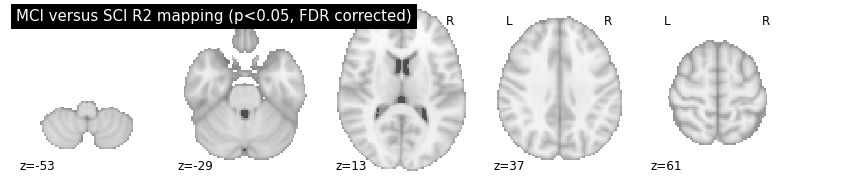

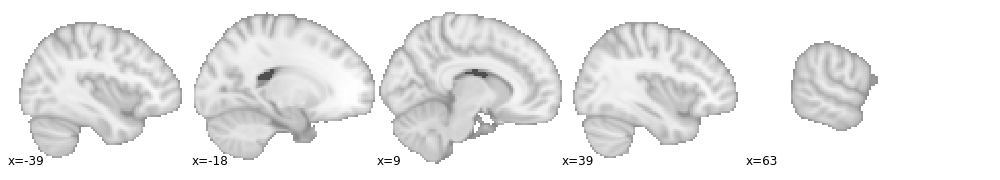

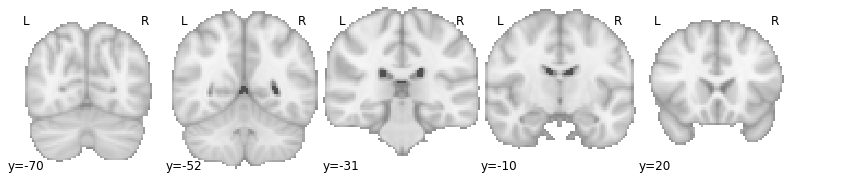

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)


In [26]:
_, threshold = map_threshold(zmap_mcisci, alpha=.05, height_control='fdr')
print('FDR, p<0.05 threshold: %.3f' % threshold)
plotting.plot_stat_map(zmap_mcisci, threshold=threshold, display_mode='z', cut_coords=5,
              title='MCI versus SCI R2 mapping (p<0.05, FDR corrected)')
plt.show()

plotting.plot_stat_map(zmap_mcisci, threshold=threshold, display_mode='x', cut_coords=5)
plt.show()

plotting.plot_stat_map(zmap_mcisci, threshold=threshold, display_mode='y', cut_coords=5)
plt.show()

get_clusters_table(zmap_mcisci, stat_threshold=threshold, cluster_threshold=None)

MCI versus PD
====

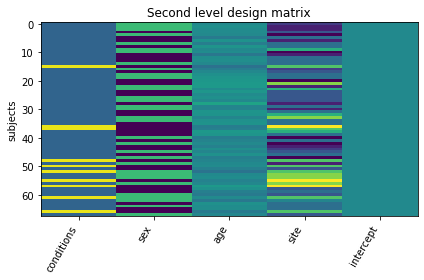

In [27]:
r2maps_mcipd = []
r2_file_mcipd = open((os.path.join(path_base,r2_path, 'ccna_r2maps_mcipd.txt')),'r')
for line in r2_file_mcipd:
    r2maps_mcipd.append(os.path.join(path_base,r2_path, (line.strip())))
r2_file_mcipd.close()

behavioral_mcipd = pd.read_csv('/home/lussier/Projects/embeddings/ccna/ccna_pheno_mcipd.csv', header = 0, sep=',')

file_id = behavioral_mcipd['FILEID'].values
conditions = behavioral_mcipd['DX_GROUP_RECODE'].values

confounds = pd.DataFrame({'subject_label': file_id,
                          'conditions': conditions,
                          'sex': behavioral_mcipd['SEX_RECODE'],
                          'age': behavioral_mcipd['AGE_AT_SCAN'],
                          'site': behavioral_mcipd['SITE_RECODE']
                         })

design_matrix = make_second_level_design_matrix(file_id, confounds)

ax = plot_design_matrix(design_matrix)
ax.set_title('Second level design matrix', fontsize=12)
ax.set_ylabel('subjects')
plt.tight_layout()
plt.show()

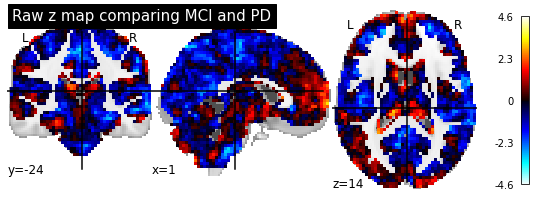

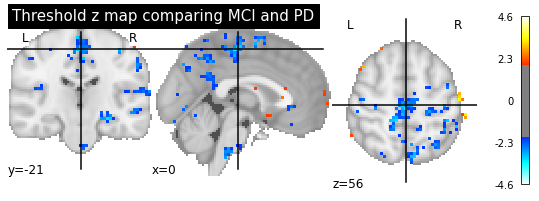

In [28]:
second_level_input = r2maps_mcipd
second_level_model = SecondLevelModel().fit(
        second_level_input, design_matrix=design_matrix)

zmap_mcipd = second_level_model.compute_contrast(
    'conditions', output_type='z_score')
plotting.plot_stat_map(zmap_mcipd, title='Raw z map comparing MCI and PD')
plotting.show()

plotting.plot_stat_map(zmap_mcipd, threshold=2, title='Threshold z map comparing MCI and PD')
plotting.show()

FDR, p<0.05 threshold: inf


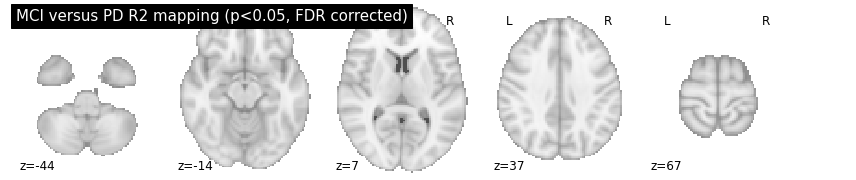

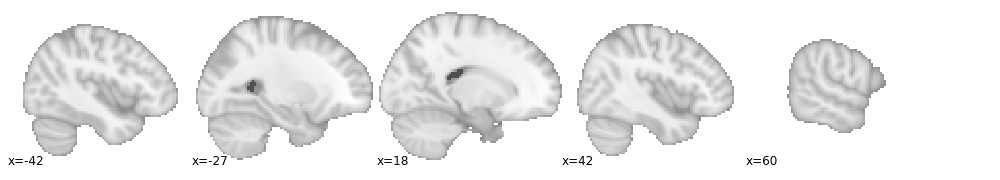

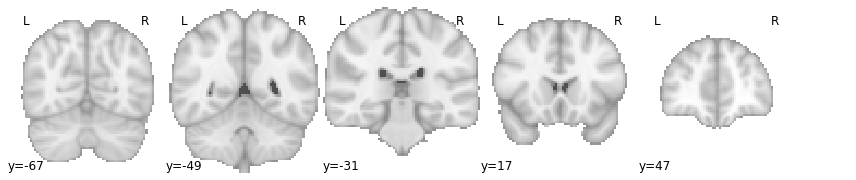

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)


In [29]:
_, threshold = map_threshold(zmap_mcipd, alpha=.05, height_control='fdr')
print('FDR, p<0.05 threshold: %.3f' % threshold)
plotting.plot_stat_map(zmap_mcipd, threshold=threshold, display_mode='z', cut_coords=5,
              title='MCI versus PD R2 mapping (p<0.05, FDR corrected)')
plt.show()

plotting.plot_stat_map(zmap_mcipd, threshold=threshold, display_mode='x', cut_coords=5)
plt.show()

plotting.plot_stat_map(zmap_mcipd, threshold=threshold, display_mode='y', cut_coords=5)
plt.show()

get_clusters_table(zmap_mcipd, stat_threshold=threshold, cluster_threshold=None)

SCI versus PD
====

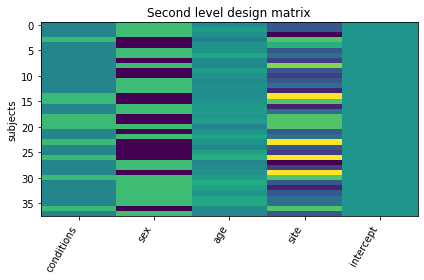

In [30]:
r2maps_scipd = []
r2_file_scipd = open((os.path.join(path_base,r2_path, 'ccna_r2maps_scipd.txt')),'r')
for line in r2_file_scipd:
    r2maps_scipd.append(os.path.join(path_base,r2_path, (line.strip())))
r2_file_scipd.close()

behavioral_scipd = pd.read_csv('/home/lussier/Projects/embeddings/ccna/ccna_pheno_scipd.csv', header = 0, sep=',')

file_id = behavioral_scipd['FILEID'].values
conditions = behavioral_scipd['DX_GROUP_RECODE'].values

confounds = pd.DataFrame({'subject_label': file_id,
                          'conditions': conditions,
                          'sex': behavioral_scipd['SEX_RECODE'],
                          'age': behavioral_scipd['AGE_AT_SCAN'],
                          'site': behavioral_scipd['SITE_RECODE']
                         })

design_matrix = make_second_level_design_matrix(file_id, confounds)

ax = plot_design_matrix(design_matrix)
ax.set_title('Second level design matrix', fontsize=12)
ax.set_ylabel('subjects')
plt.tight_layout()
plt.show()

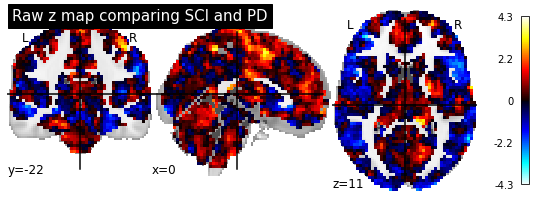

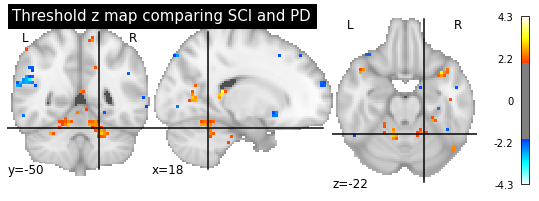

In [31]:
second_level_input = r2maps_scipd
second_level_model = SecondLevelModel().fit(
        second_level_input, design_matrix=design_matrix)

zmap_scipd = second_level_model.compute_contrast(
    'conditions', output_type='z_score')
plotting.plot_stat_map(zmap_scipd, title='Raw z map comparing SCI and PD')
plotting.show()

plotting.plot_stat_map(zmap_scipd, threshold=2, title='Threshold z map comparing SCI and PD')
plotting.show()

FDR, p<0.05 threshold: inf


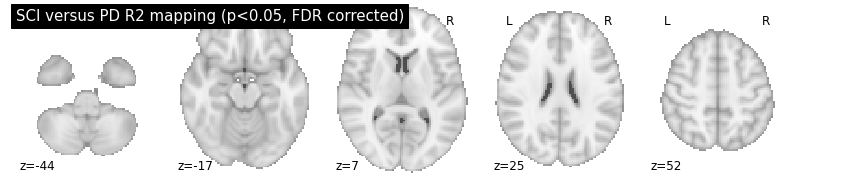

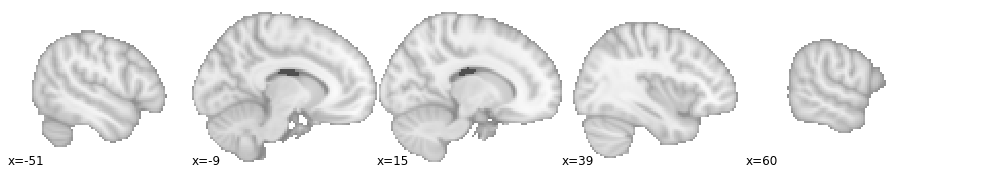

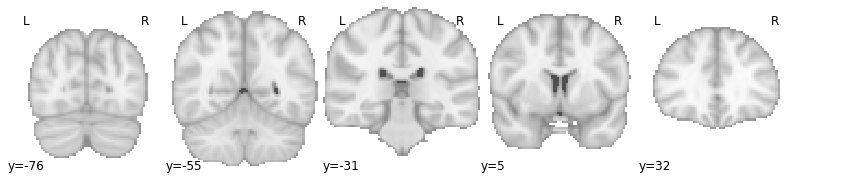

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)


In [32]:
_, threshold = map_threshold(zmap_scipd, alpha=.05, height_control='fdr')
print('FDR, p<0.05 threshold: %.3f' % threshold)
plotting.plot_stat_map(zmap_scipd, threshold=threshold, display_mode='z', cut_coords=5,
              title='SCI versus PD R2 mapping (p<0.05, FDR corrected)')
plt.show()

plotting.plot_stat_map(zmap_scipd, threshold=threshold, display_mode='x', cut_coords=5)
plt.show()

plotting.plot_stat_map(zmap_scipd, threshold=threshold, display_mode='y', cut_coords=5)
plt.show()

get_clusters_table(zmap_scipd, stat_threshold=threshold, cluster_threshold=None)

Site comparisons
============
Now we compare embedding quality of different sites with eachother in the sample.

CBH versus UOA
====

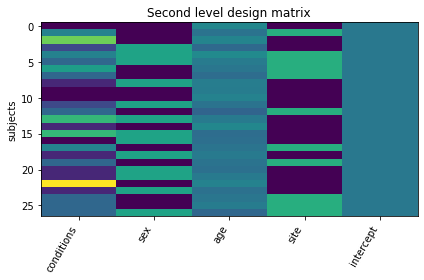

In [33]:
r2maps_cbh_uoa = []
r2_file_cbh_uoa = open((os.path.join(path_base,r2_path, 'ccna_r2maps_cbh_uoa.txt')),'r')
for line in r2_file_cbh_uoa:
    r2maps_cbh_uoa.append(os.path.join(path_base,r2_path, (line.strip())))
r2_file_cbh_uoa.close()

behavioral_cbh_uoa = pd.read_csv('/home/lussier/Projects/embeddings/ccna/ccna_pheno_cbh_uoa.csv', header = 0, sep=',')

file_id = behavioral_cbh_uoa['FILEID'].values
conditions = behavioral_cbh_uoa['DX_GROUP_RECODE'].values

confounds = pd.DataFrame({'subject_label': file_id,
                          'conditions': conditions,
                          'sex': behavioral_cbh_uoa['SEX_RECODE'],
                          'age': behavioral_cbh_uoa['AGE_AT_SCAN'],
                          'site': behavioral_cbh_uoa['SITE_RECODE']
                         })

design_matrix = make_second_level_design_matrix(file_id, confounds)

ax = plot_design_matrix(design_matrix)
ax.set_title('Second level design matrix', fontsize=12)
ax.set_ylabel('subjects')
plt.tight_layout()
plt.show()

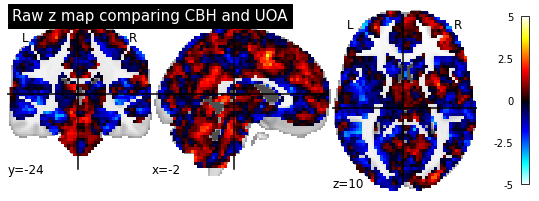

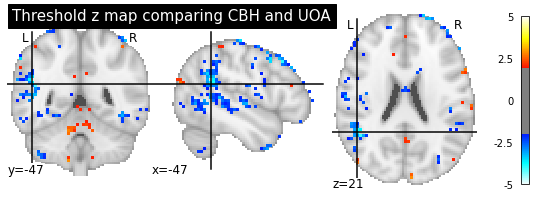

In [34]:
second_level_input = r2maps_cbh_uoa
second_level_model = SecondLevelModel().fit(
        second_level_input, design_matrix=design_matrix)

zmap_cbh_uoa = second_level_model.compute_contrast(
    'site', output_type='z_score')
plotting.plot_stat_map(zmap_cbh_uoa, title='Raw z map comparing CBH and UOA')
plotting.show()

plotting.plot_stat_map(zmap_cbh_uoa, threshold=2, title='Threshold z map comparing CBH and UOA')
plotting.show()

FDR, p<0.05 threshold: inf


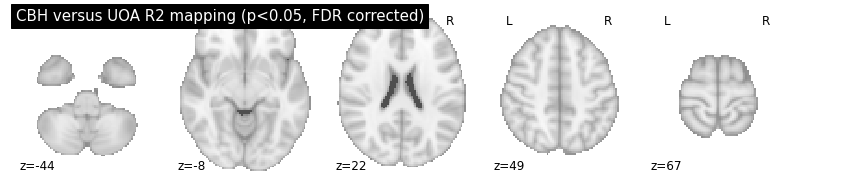

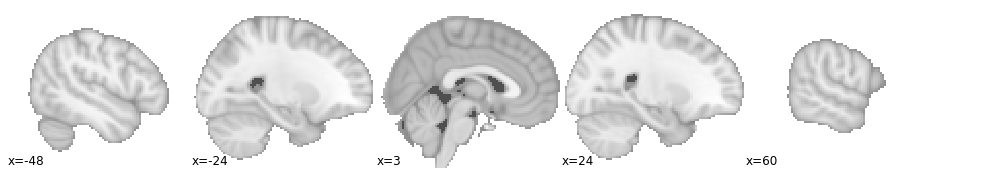

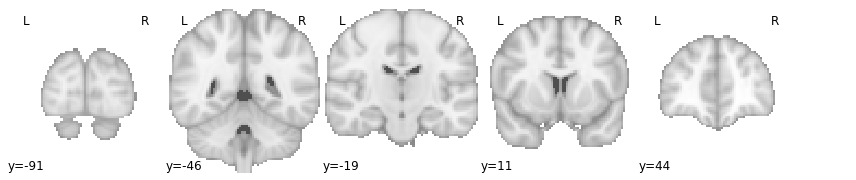

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)


In [35]:
_, threshold = map_threshold(zmap_cbh_uoa, alpha=.05, height_control='fdr')
print('FDR, p<0.05 threshold: %.3f' % threshold)
plotting.plot_stat_map(zmap_cbh_uoa, threshold=threshold, display_mode='z', cut_coords=5,
              title='CBH versus UOA R2 mapping (p<0.05, FDR corrected)')
plt.show()

plotting.plot_stat_map(zmap_cbh_uoa, threshold=threshold, display_mode='x', cut_coords=5)
plt.show()

plotting.plot_stat_map(zmap_cbh_uoa, threshold=threshold, display_mode='y', cut_coords=5)
plt.show()

get_clusters_table(zmap_cbh_uoa, stat_threshold=threshold, cluster_threshold=None)

CBH versus PKM
====

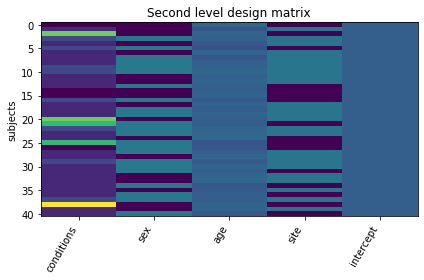

In [36]:
r2maps_cbh_pkm = []
r2_file_cbh_pkm = open((os.path.join(path_base,r2_path, 'ccna_r2maps_cbh_pkm.txt')),'r')
for line in r2_file_cbh_pkm:
    r2maps_cbh_pkm.append(os.path.join(path_base,r2_path, (line.strip())))
r2_file_cbh_pkm.close()

behavioral_cbh_pkm = pd.read_csv('/home/lussier/Projects/embeddings/ccna/ccna_pheno_cbh_pkm.csv', header = 0, sep=',')

file_id = behavioral_cbh_pkm['FILEID'].values
conditions = behavioral_cbh_pkm['DX_GROUP_RECODE'].values

confounds = pd.DataFrame({'subject_label': file_id,
                          'conditions': conditions,
                          'sex': behavioral_cbh_pkm['SEX_RECODE'],
                          'age': behavioral_cbh_pkm['AGE_AT_SCAN'],
                          'site': behavioral_cbh_pkm['SITE_RECODE']
                         })

design_matrix = make_second_level_design_matrix(file_id, confounds)

ax = plot_design_matrix(design_matrix)
ax.set_title('Second level design matrix', fontsize=12)
ax.set_ylabel('subjects')
plt.tight_layout()
plt.show()

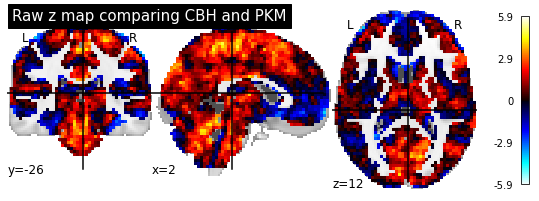

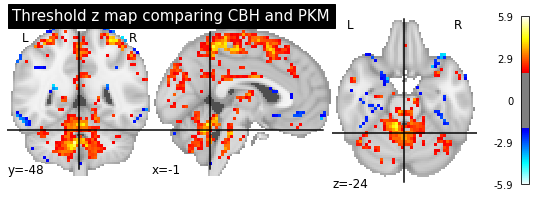

In [37]:
second_level_input = r2maps_cbh_pkm
second_level_model = SecondLevelModel().fit(
        second_level_input, design_matrix=design_matrix)

zmap_cbh_pkm = second_level_model.compute_contrast(
    'site', output_type='z_score')
plotting.plot_stat_map(zmap_cbh_pkm, title='Raw z map comparing CBH and PKM')
plotting.show()

plotting.plot_stat_map(zmap_cbh_pkm, threshold=2, title='Threshold z map comparing CBH and PKM')
plotting.show()

FDR, p<0.05 threshold: 3.077


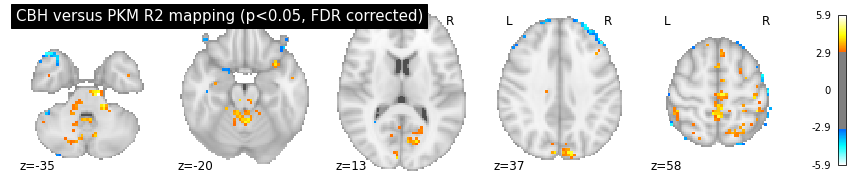

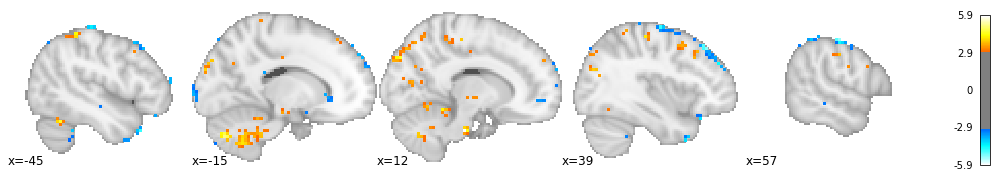

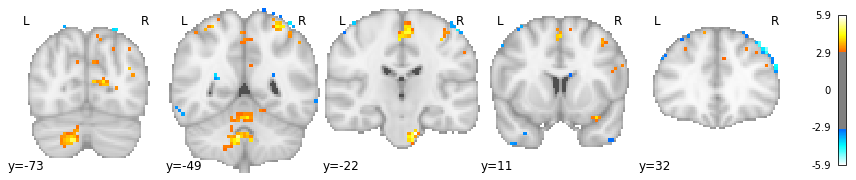

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)
0,1,12.0,-22.0,-35.0,5.889235,12258
1,1a,-6.0,-49.0,-38.0,5.277970,
2,1b,-15.0,-76.0,-41.0,5.092374,
3,1c,-9.0,-58.0,-29.0,4.681891,
4,2,48.0,-37.0,55.0,4.948183,513
...,...,...,...,...,...,...
289,266,24.0,26.0,49.0,3.081447,27
290,267,-3.0,-64.0,-38.0,3.081407,27
291,268,-3.0,-70.0,-5.0,3.080254,27
292,269,9.0,-37.0,-38.0,3.079966,27


In [38]:
_, threshold = map_threshold(zmap_cbh_pkm, alpha=.05, height_control='fdr')
print('FDR, p<0.05 threshold: %.3f' % threshold)
plotting.plot_stat_map(zmap_cbh_pkm, threshold=threshold, display_mode='z', cut_coords=5,
              title='CBH versus PKM R2 mapping (p<0.05, FDR corrected)')
plt.show()

plotting.plot_stat_map(zmap_cbh_pkm, threshold=threshold, display_mode='x', cut_coords=5)
plt.show()

plotting.plot_stat_map(zmap_cbh_pkm, threshold=threshold, display_mode='y', cut_coords=5)
plt.show()

get_clusters_table(zmap_cbh_pkm, stat_threshold=threshold, cluster_threshold=None)

CBH versus PKD
====

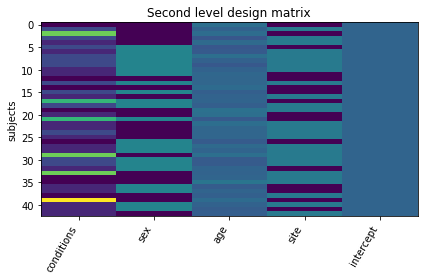

In [39]:
r2maps_cbh_pkd = []
r2_file_cbh_pkd = open((os.path.join(path_base,r2_path, 'ccna_r2maps_cbh_pkd.txt')),'r')
for line in r2_file_cbh_pkd:
    r2maps_cbh_pkd.append(os.path.join(path_base,r2_path, (line.strip())))
r2_file_cbh_pkd.close()

behavioral_cbh_pkd = pd.read_csv('/home/lussier/Projects/embeddings/ccna/ccna_pheno_cbh_pkd.csv', header = 0, sep=',')

file_id = behavioral_cbh_pkd['FILEID'].values
conditions = behavioral_cbh_pkd['DX_GROUP_RECODE'].values

confounds = pd.DataFrame({'subject_label': file_id,
                          'conditions': conditions,
                          'sex': behavioral_cbh_pkd['SEX_RECODE'],
                          'age': behavioral_cbh_pkd['AGE_AT_SCAN'],
                          'site': behavioral_cbh_pkd['SITE_RECODE']
                         })

design_matrix = make_second_level_design_matrix(file_id, confounds)

ax = plot_design_matrix(design_matrix)
ax.set_title('Second level design matrix', fontsize=12)
ax.set_ylabel('subjects')
plt.tight_layout()
plt.show()

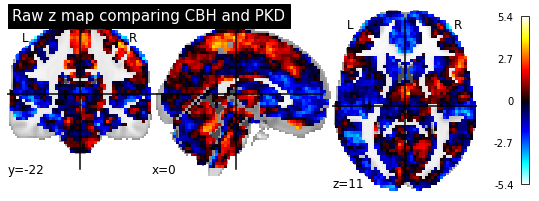

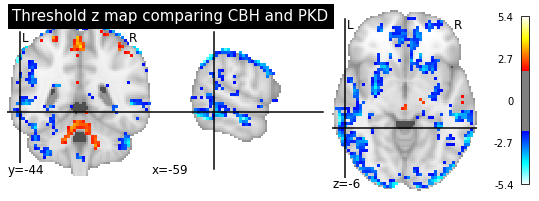

In [40]:
second_level_input = r2maps_cbh_pkd
second_level_model = SecondLevelModel().fit(
        second_level_input, design_matrix=design_matrix)

zmap_cbh_pkd = second_level_model.compute_contrast(
    'site', output_type='z_score')
plotting.plot_stat_map(zmap_cbh_pkd, title='Raw z map comparing CBH and PKD')
plotting.show()

plotting.plot_stat_map(zmap_cbh_pkd, threshold=2, title='Threshold z map comparing CBH and PKD')
plotting.show()

FDR, p<0.05 threshold: 3.201


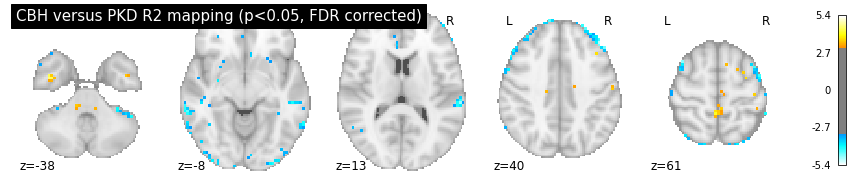

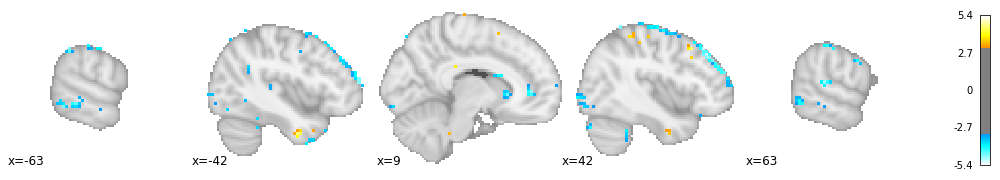

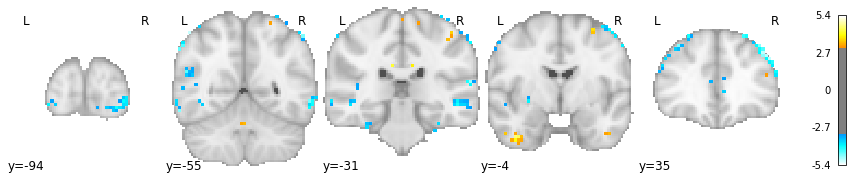

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)
0,1,-42.0,-4.0,-38.0,4.667967,378
1,2,42.0,20.0,46.0,4.521533,108
2,3,39.0,23.0,37.0,4.418558,162
3,4,-9.0,-31.0,28.0,4.286080,54
4,5,51.0,-13.0,46.0,4.262863,324
...,...,...,...,...,...,...
72,71,6.0,-22.0,61.0,3.233454,27
73,72,-9.0,-58.0,-29.0,3.225707,27
74,73,3.0,-10.0,28.0,3.224014,27
75,74,36.0,11.0,-17.0,3.222146,27


In [41]:
_, threshold = map_threshold(zmap_cbh_pkd, alpha=.05, height_control='fdr')
print('FDR, p<0.05 threshold: %.3f' % threshold)
plotting.plot_stat_map(zmap_cbh_pkd, threshold=threshold, display_mode='z', cut_coords=5,
              title='CBH versus PKD R2 mapping (p<0.05, FDR corrected)')
plt.show()

plotting.plot_stat_map(zmap_cbh_pkd, threshold=threshold, display_mode='x', cut_coords=5)
plt.show()

plotting.plot_stat_map(zmap_cbh_pkd, threshold=threshold, display_mode='y', cut_coords=5)
plt.show()

get_clusters_table(zmap_cbh_pkd, stat_threshold=threshold, cluster_threshold=None)

CBH versus JGH
====

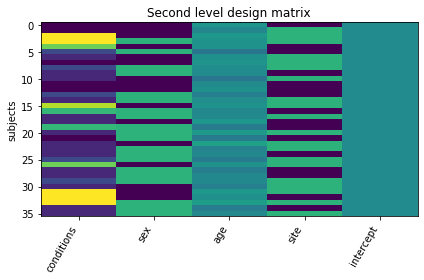

In [42]:
r2maps_cbh_jgh = []
r2_file_cbh_jgh = open((os.path.join(path_base,r2_path, 'ccna_r2maps_cbh_jgh.txt')),'r')
for line in r2_file_cbh_jgh:
    r2maps_cbh_jgh.append(os.path.join(path_base,r2_path, (line.strip())))
r2_file_cbh_jgh.close()

behavioral_cbh_jgh = pd.read_csv('/home/lussier/Projects/embeddings/ccna/ccna_pheno_cbh_jgh.csv', header = 0, sep=',')

file_id = behavioral_cbh_jgh['FILEID'].values
conditions = behavioral_cbh_jgh['DX_GROUP_RECODE'].values

confounds = pd.DataFrame({'subject_label': file_id,
                          'conditions': conditions,
                          'sex': behavioral_cbh_jgh['SEX_RECODE'],
                          'age': behavioral_cbh_jgh['AGE_AT_SCAN'],
                          'site': behavioral_cbh_jgh['SITE_RECODE']
                         })

design_matrix = make_second_level_design_matrix(file_id, confounds)

ax = plot_design_matrix(design_matrix)
ax.set_title('Second level design matrix', fontsize=12)
ax.set_ylabel('subjects')
plt.tight_layout()
plt.show()

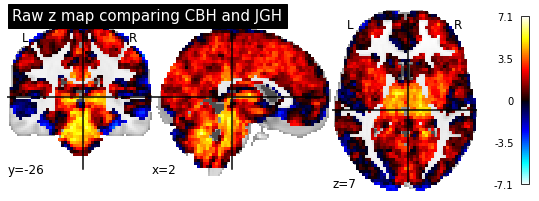

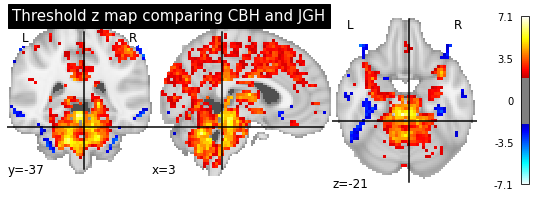

In [43]:
second_level_input = r2maps_cbh_jgh
second_level_model = SecondLevelModel().fit(
        second_level_input, design_matrix=design_matrix)

zmap_cbh_jgh = second_level_model.compute_contrast(
    'site', output_type='z_score')
plotting.plot_stat_map(zmap_cbh_jgh, title='Raw z map comparing CBH and JGH')
plotting.show()

plotting.plot_stat_map(zmap_cbh_jgh, threshold=2, title='Threshold z map comparing CBH and JGH')
plotting.show()

FDR, p<0.05 threshold: 2.663


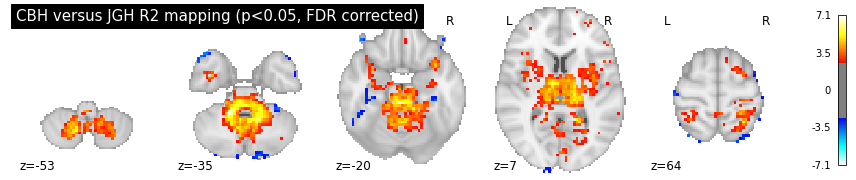

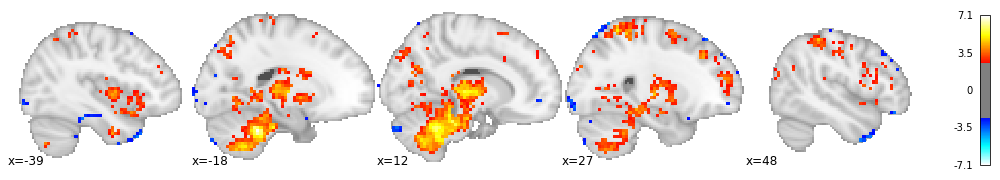

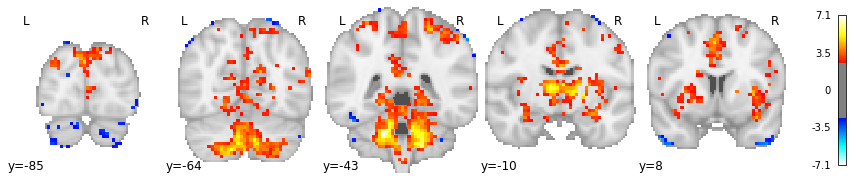

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)
0,1,-18.0,-43.0,-35.0,7.091061,140994
1,1a,-3.0,-31.0,-20.0,6.681964,
2,1b,-3.0,-37.0,-11.0,6.431107,
3,1c,3.0,-58.0,-29.0,6.218509,
4,2,27.0,-52.0,64.0,5.137277,7965
...,...,...,...,...,...,...
334,301,42.0,38.0,16.0,2.667594,27
335,302,-42.0,23.0,7.0,2.665778,27
336,303,21.0,-58.0,49.0,2.664952,27
337,304,-57.0,-28.0,49.0,2.663890,27


In [44]:
_, threshold = map_threshold(zmap_cbh_jgh, alpha=.05, height_control='fdr')
print('FDR, p<0.05 threshold: %.3f' % threshold)
plotting.plot_stat_map(zmap_cbh_jgh, threshold=threshold, display_mode='z', cut_coords=5,
              title='CBH versus JGH R2 mapping (p<0.05, FDR corrected)')
plt.show()

plotting.plot_stat_map(zmap_cbh_jgh, threshold=threshold, display_mode='x', cut_coords=5)
plt.show()

plotting.plot_stat_map(zmap_cbh_jgh, threshold=threshold, display_mode='y', cut_coords=5)
plt.show()

get_clusters_table(zmap_cbh_jgh, stat_threshold=threshold, cluster_threshold=None)

UOA versus PKM
====

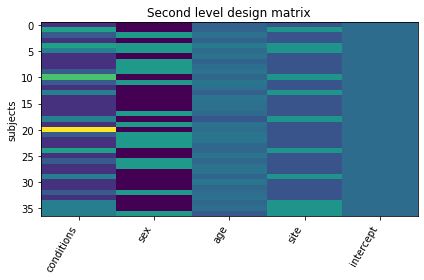

In [45]:
r2maps_uoa_pkm = []
r2_file_uoa_pkm = open((os.path.join(path_base,r2_path, 'ccna_r2maps_uoa_pkm.txt')),'r')
for line in r2_file_uoa_pkm:
    r2maps_uoa_pkm.append(os.path.join(path_base,r2_path, (line.strip())))
r2_file_uoa_pkm.close()

behavioral_uoa_pkm = pd.read_csv('/home/lussier/Projects/embeddings/ccna/ccna_pheno_uoa_pkm.csv', header = 0, sep=',')

file_id = behavioral_uoa_pkm['FILEID'].values
conditions = behavioral_uoa_pkm['DX_GROUP_RECODE'].values

confounds = pd.DataFrame({'subject_label': file_id,
                          'conditions': conditions,
                          'sex': behavioral_uoa_pkm['SEX_RECODE'],
                          'age': behavioral_uoa_pkm['AGE_AT_SCAN'],
                          'site': behavioral_uoa_pkm['SITE_RECODE']
                         })

design_matrix = make_second_level_design_matrix(file_id, confounds)

ax = plot_design_matrix(design_matrix)
ax.set_title('Second level design matrix', fontsize=12)
ax.set_ylabel('subjects')
plt.tight_layout()
plt.show()

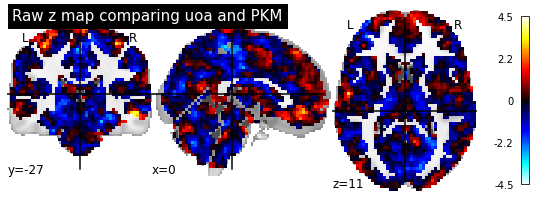

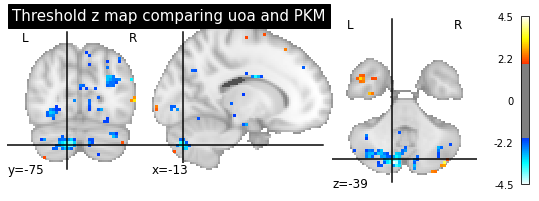

In [46]:
second_level_input = r2maps_uoa_pkm
second_level_model = SecondLevelModel().fit(
        second_level_input, design_matrix=design_matrix)

zmap_uoa_pkm = second_level_model.compute_contrast(
    'site', output_type='z_score')
plotting.plot_stat_map(zmap_uoa_pkm, title='Raw z map comparing uoa and PKM')
plotting.show()

plotting.plot_stat_map(zmap_uoa_pkm, threshold=2, title='Threshold z map comparing uoa and PKM')
plotting.show()

FDR, p<0.05 threshold: inf


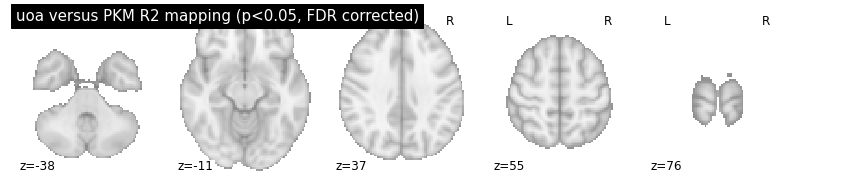

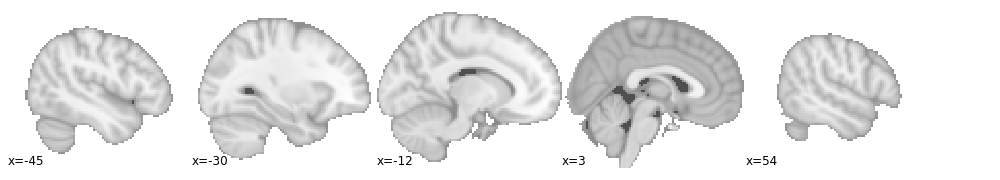

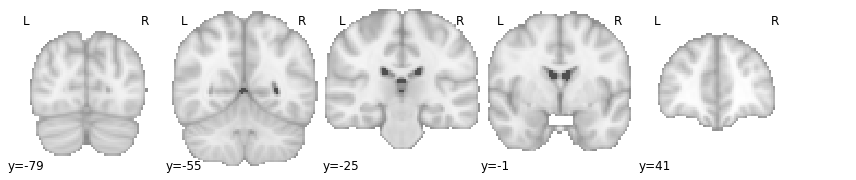

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)


In [47]:
_, threshold = map_threshold(zmap_uoa_pkm, alpha=.05, height_control='fdr')
print('FDR, p<0.05 threshold: %.3f' % threshold)
plotting.plot_stat_map(zmap_uoa_pkm, threshold=threshold, display_mode='z', cut_coords=5,
              title='uoa versus PKM R2 mapping (p<0.05, FDR corrected)')
plt.show()

plotting.plot_stat_map(zmap_uoa_pkm, threshold=threshold, display_mode='x', cut_coords=5)
plt.show()

plotting.plot_stat_map(zmap_uoa_pkm, threshold=threshold, display_mode='y', cut_coords=5)
plt.show()

get_clusters_table(zmap_uoa_pkm, stat_threshold=threshold, cluster_threshold=None)

UOA versus PKD
====

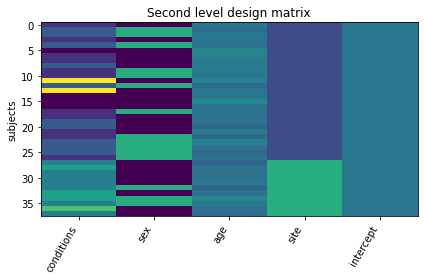

In [48]:
r2maps_uoa_pkd = []
r2_file_uoa_pkd = open((os.path.join(path_base,r2_path, 'ccna_r2maps_uoa_pkd.txt')),'r')
for line in r2_file_uoa_pkd:
    r2maps_uoa_pkd.append(os.path.join(path_base,r2_path, (line.strip())))
r2_file_uoa_pkd.close()

behavioral_uoa_pkd = pd.read_csv('/home/lussier/Projects/embeddings/ccna/ccna_pheno_uoa_pkd.csv', header = 0, sep=',')

file_id = behavioral_uoa_pkd['FILEID'].values
conditions = behavioral_uoa_pkd['DX_GROUP_RECODE'].values

confounds = pd.DataFrame({'subject_label': file_id,
                          'conditions': conditions,
                          'sex': behavioral_uoa_pkd['SEX_RECODE'],
                          'age': behavioral_uoa_pkd['AGE_AT_SCAN'],
                          'site': behavioral_uoa_pkd['SITE_RECODE']
                         })

design_matrix = make_second_level_design_matrix(file_id, confounds)

ax = plot_design_matrix(design_matrix)
ax.set_title('Second level design matrix', fontsize=12)
ax.set_ylabel('subjects')
plt.tight_layout()
plt.show()

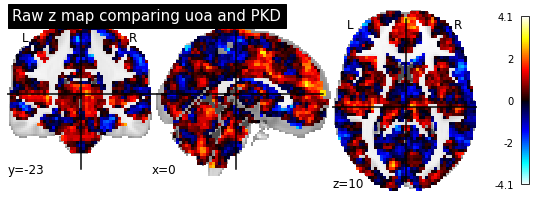

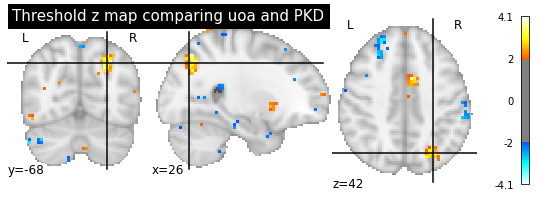

In [49]:
second_level_input = r2maps_uoa_pkd
second_level_model = SecondLevelModel().fit(
        second_level_input, design_matrix=design_matrix)

zmap_uoa_pkd = second_level_model.compute_contrast(
    'site', output_type='z_score')
plotting.plot_stat_map(zmap_uoa_pkd, title='Raw z map comparing uoa and PKD')
plotting.show()

plotting.plot_stat_map(zmap_uoa_pkd, threshold=2, title='Threshold z map comparing uoa and PKD')
plotting.show()

FDR, p<0.05 threshold: inf


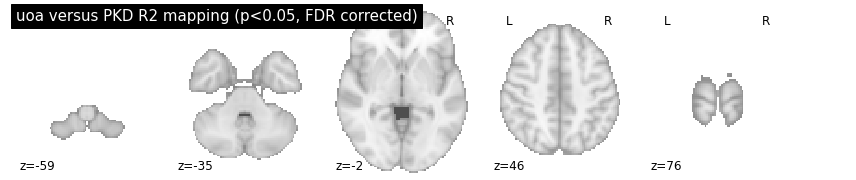

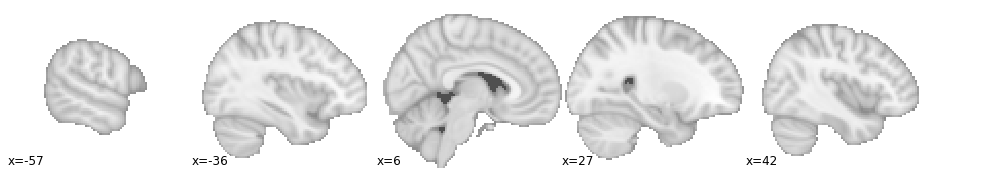

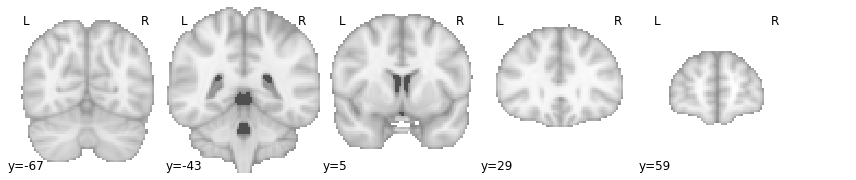

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)


In [50]:
_, threshold = map_threshold(zmap_uoa_pkd, alpha=.05, height_control='fdr')
print('FDR, p<0.05 threshold: %.3f' % threshold)
plotting.plot_stat_map(zmap_uoa_pkd, threshold=threshold, display_mode='z', cut_coords=5,
              title='uoa versus PKD R2 mapping (p<0.05, FDR corrected)')
plt.show()

plotting.plot_stat_map(zmap_uoa_pkd, threshold=threshold, display_mode='x', cut_coords=5)
plt.show()

plotting.plot_stat_map(zmap_uoa_pkd, threshold=threshold, display_mode='y', cut_coords=5)
plt.show()

get_clusters_table(zmap_uoa_pkd, stat_threshold=threshold, cluster_threshold=None)

UOA versus JGH
====

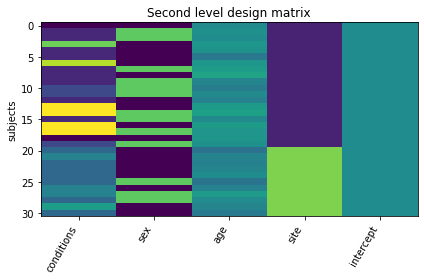

In [51]:
r2maps_uoa_jgh = []
r2_file_uoa_jgh = open((os.path.join(path_base,r2_path, 'ccna_r2maps_uoa_jgh.txt')),'r')
for line in r2_file_uoa_jgh:
    r2maps_uoa_jgh.append(os.path.join(path_base,r2_path, (line.strip())))
r2_file_uoa_jgh.close()

behavioral_uoa_jgh = pd.read_csv('/home/lussier/Projects/embeddings/ccna/ccna_pheno_uoa_jgh.csv', header = 0, sep=',')

file_id = behavioral_uoa_jgh['FILEID'].values
conditions = behavioral_uoa_jgh['DX_GROUP_RECODE'].values

confounds = pd.DataFrame({'subject_label': file_id,
                          'conditions': conditions,
                          'sex': behavioral_uoa_jgh['SEX_RECODE'],
                          'age': behavioral_uoa_jgh['AGE_AT_SCAN'],
                          'site': behavioral_uoa_jgh['SITE_RECODE']
                         })

design_matrix = make_second_level_design_matrix(file_id, confounds)

ax = plot_design_matrix(design_matrix)
ax.set_title('Second level design matrix', fontsize=12)
ax.set_ylabel('subjects')
plt.tight_layout()
plt.show()

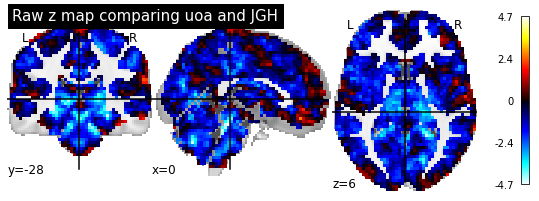

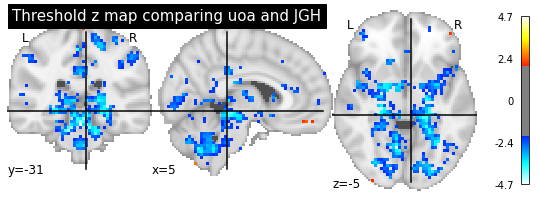

In [52]:
second_level_input = r2maps_uoa_jgh
second_level_model = SecondLevelModel().fit(
        second_level_input, design_matrix=design_matrix)

zmap_uoa_jgh = second_level_model.compute_contrast(
    'site', output_type='z_score')
plotting.plot_stat_map(zmap_uoa_jgh, title='Raw z map comparing uoa and JGH')
plotting.show()

plotting.plot_stat_map(zmap_uoa_jgh, threshold=2, title='Threshold z map comparing uoa and JGH')
plotting.show()

FDR, p<0.05 threshold: inf


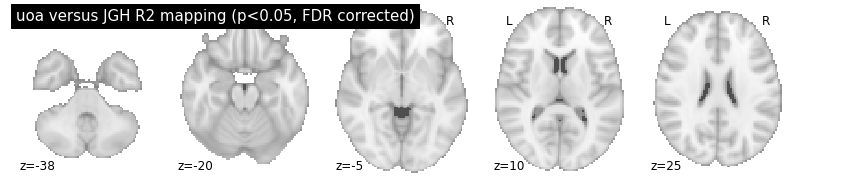

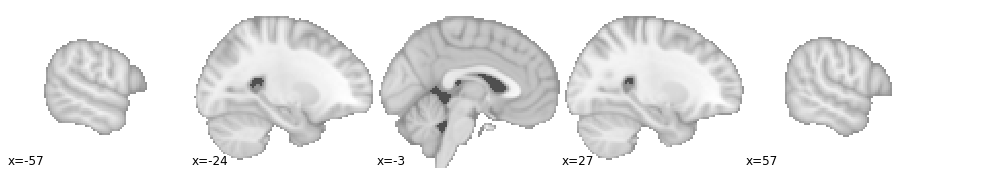

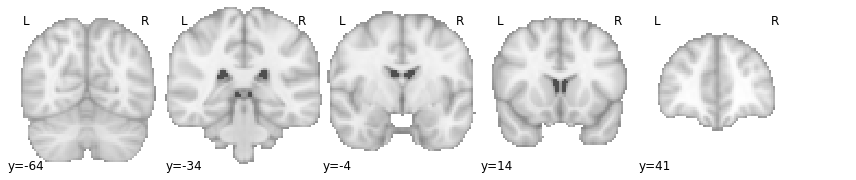

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)


In [53]:
_, threshold = map_threshold(zmap_uoa_jgh, alpha=.05, height_control='fdr')
print('FDR, p<0.05 threshold: %.3f' % threshold)
plotting.plot_stat_map(zmap_uoa_jgh, threshold=threshold, display_mode='z', cut_coords=5,
              title='uoa versus JGH R2 mapping (p<0.05, FDR corrected)')
plt.show()

plotting.plot_stat_map(zmap_uoa_jgh, threshold=threshold, display_mode='x', cut_coords=5)
plt.show()

plotting.plot_stat_map(zmap_uoa_jgh, threshold=threshold, display_mode='y', cut_coords=5)
plt.show()

get_clusters_table(zmap_uoa_jgh, stat_threshold=threshold, cluster_threshold=None)

PKM versus PKD
====

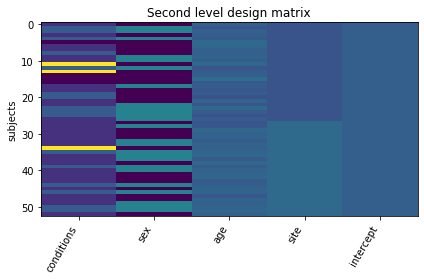

In [54]:
r2maps_pkm_pkd = []
r2_file_pkm_pkd = open((os.path.join(path_base,r2_path, 'ccna_r2maps_pkm_pkd.txt')),'r')
for line in r2_file_pkm_pkd:
    r2maps_pkm_pkd.append(os.path.join(path_base,r2_path, (line.strip())))
r2_file_pkm_pkd.close()

behavioral_pkm_pkd = pd.read_csv('/home/lussier/Projects/embeddings/ccna/ccna_pheno_pkm_pkd.csv', header = 0, sep=',')

file_id = behavioral_pkm_pkd['FILEID'].values
conditions = behavioral_pkm_pkd['DX_GROUP_RECODE'].values

confounds = pd.DataFrame({'subject_label': file_id,
                          'conditions': conditions,
                          'sex': behavioral_pkm_pkd['SEX_RECODE'],
                          'age': behavioral_pkm_pkd['AGE_AT_SCAN'],
                          'site': behavioral_pkm_pkd['SITE_RECODE']
                         })

design_matrix = make_second_level_design_matrix(file_id, confounds)

ax = plot_design_matrix(design_matrix)
ax.set_title('Second level design matrix', fontsize=12)
ax.set_ylabel('subjects')
plt.tight_layout()
plt.show()

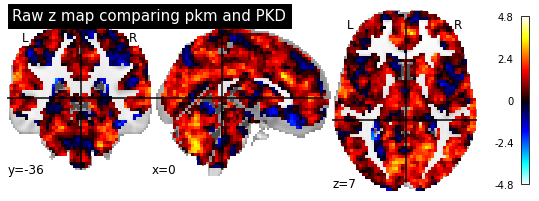

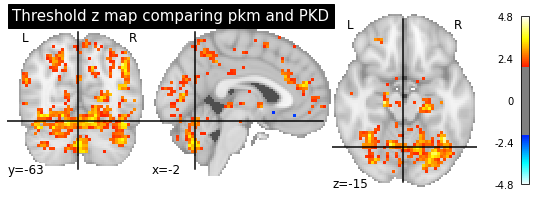

In [55]:
second_level_input = r2maps_pkm_pkd
second_level_model = SecondLevelModel().fit(
        second_level_input, design_matrix=design_matrix)

zmap_pkm_pkd = second_level_model.compute_contrast(
    'site', output_type='z_score')
plotting.plot_stat_map(zmap_pkm_pkd, title='Raw z map comparing pkm and PKD')
plotting.show()

plotting.plot_stat_map(zmap_pkm_pkd, threshold=2, title='Threshold z map comparing pkm and PKD')
plotting.show()

FDR, p<0.05 threshold: inf


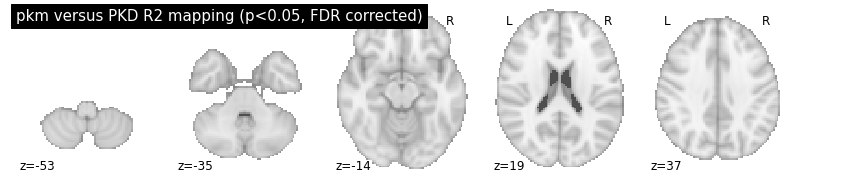

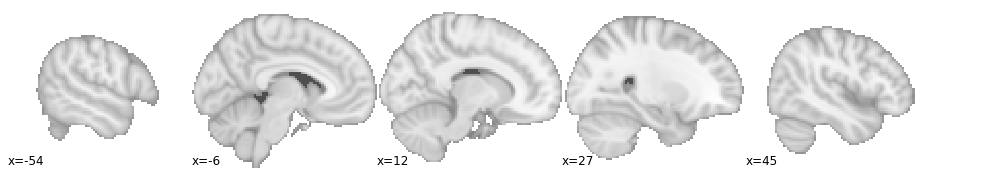

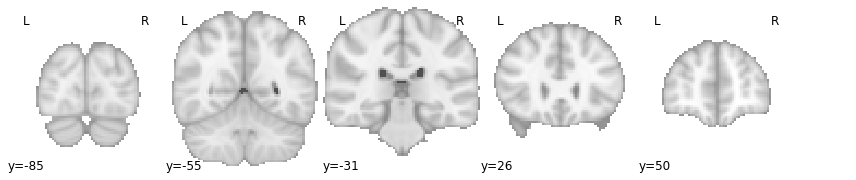

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)


In [56]:
_, threshold = map_threshold(zmap_pkm_pkd, alpha=.05, height_control='fdr')
print('FDR, p<0.05 threshold: %.3f' % threshold)
plotting.plot_stat_map(zmap_pkm_pkd, threshold=threshold, display_mode='z', cut_coords=5,
              title='pkm versus PKD R2 mapping (p<0.05, FDR corrected)')
plt.show()

plotting.plot_stat_map(zmap_pkm_pkd, threshold=threshold, display_mode='x', cut_coords=5)
plt.show()

plotting.plot_stat_map(zmap_pkm_pkd, threshold=threshold, display_mode='y', cut_coords=5)
plt.show()

get_clusters_table(zmap_pkm_pkd, stat_threshold=threshold, cluster_threshold=None)

PKM versus JGH
====

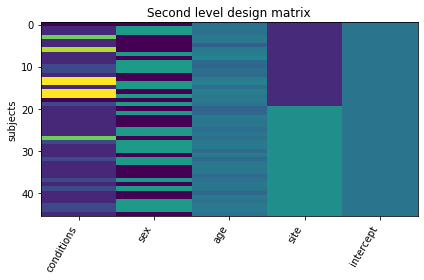

In [57]:
r2maps_pkm_jgh = []
r2_file_pkm_jgh = open((os.path.join(path_base,r2_path, 'ccna_r2maps_pkm_jgh.txt')),'r')
for line in r2_file_pkm_jgh:
    r2maps_pkm_jgh.append(os.path.join(path_base,r2_path, (line.strip())))
r2_file_pkm_jgh.close()

behavioral_pkm_jgh = pd.read_csv('/home/lussier/Projects/embeddings/ccna/ccna_pheno_pkm_jgh.csv', header = 0, sep=',')

file_id = behavioral_pkm_jgh['FILEID'].values
conditions = behavioral_pkm_jgh['DX_GROUP_RECODE'].values

confounds = pd.DataFrame({'subject_label': file_id,
                          'conditions': conditions,
                          'sex': behavioral_pkm_jgh['SEX_RECODE'],
                          'age': behavioral_pkm_jgh['AGE_AT_SCAN'],
                          'site': behavioral_pkm_jgh['SITE_RECODE']
                         })

design_matrix = make_second_level_design_matrix(file_id, confounds)

ax = plot_design_matrix(design_matrix)
ax.set_title('Second level design matrix', fontsize=12)
ax.set_ylabel('subjects')
plt.tight_layout()
plt.show()

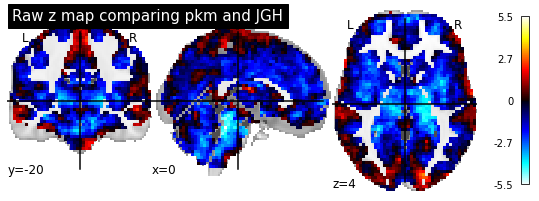

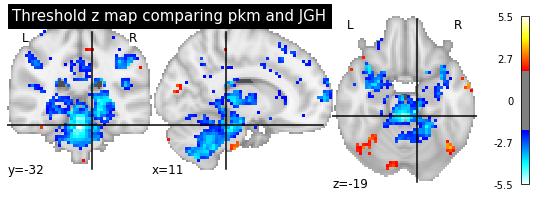

In [58]:
second_level_input = r2maps_pkm_jgh
second_level_model = SecondLevelModel().fit(
        second_level_input, design_matrix=design_matrix)

zmap_pkm_jgh = second_level_model.compute_contrast(
    'site', output_type='z_score')
plotting.plot_stat_map(zmap_pkm_jgh, title='Raw z map comparing pkm and JGH')
plotting.show()

plotting.plot_stat_map(zmap_pkm_jgh, threshold=2, title='Threshold z map comparing pkm and JGH')
plotting.show()

FDR, p<0.05 threshold: 3.103


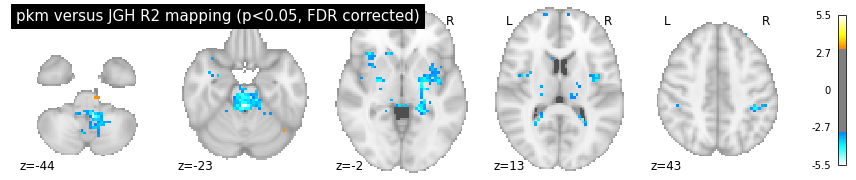

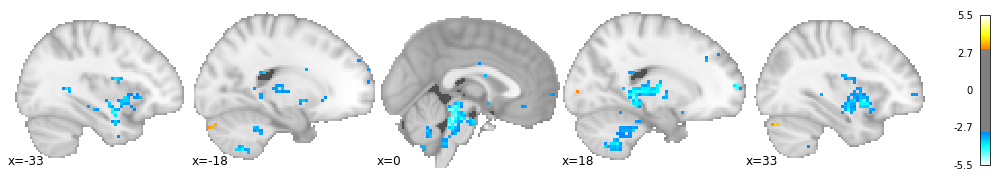

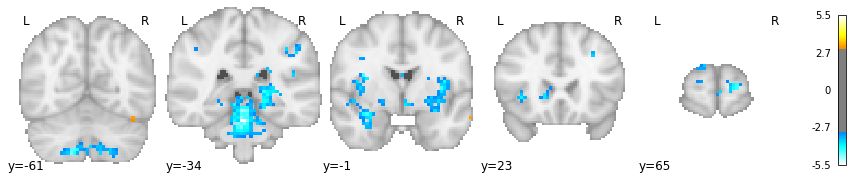

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)
0,1,36.0,-76.0,-29.0,4.124363,189
1,2,45.0,-64.0,-20.0,3.593152,108
2,3,-12.0,-85.0,-32.0,3.543157,243
3,4,-45.0,-55.0,-26.0,3.417947,27
4,5,-18.0,-85.0,-29.0,3.357900,27
5,6,-36.0,-64.0,-17.0,3.324875,54
6,7,63.0,-1.0,-20.0,3.264393,54
7,8,9.0,-25.0,-44.0,3.214999,108
8,9,-36.0,-55.0,-17.0,3.213057,27
9,10,18.0,-91.0,4.0,3.103544,27


In [59]:
_, threshold = map_threshold(zmap_pkm_jgh, alpha=.05, height_control='fdr')
print('FDR, p<0.05 threshold: %.3f' % threshold)
plotting.plot_stat_map(zmap_pkm_jgh, threshold=threshold, display_mode='z', cut_coords=5,
              title='pkm versus JGH R2 mapping (p<0.05, FDR corrected)')
plt.show()

plotting.plot_stat_map(zmap_pkm_jgh, threshold=threshold, display_mode='x', cut_coords=5)
plt.show()

plotting.plot_stat_map(zmap_pkm_jgh, threshold=threshold, display_mode='y', cut_coords=5)
plt.show()

get_clusters_table(zmap_pkm_jgh, stat_threshold=threshold, cluster_threshold=None)

PKD versus JGH
====

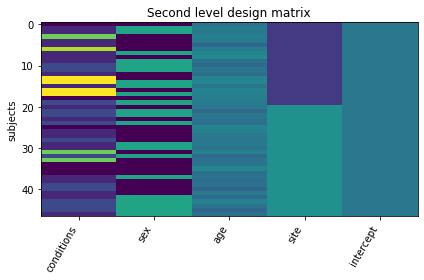

In [60]:
r2maps_pkd_jgh = []
r2_file_pkd_jgh = open((os.path.join(path_base,r2_path, 'ccna_r2maps_pkd_jgh.txt')),'r')
for line in r2_file_pkd_jgh:
    r2maps_pkd_jgh.append(os.path.join(path_base,r2_path, (line.strip())))
r2_file_pkd_jgh.close()

behavioral_pkd_jgh = pd.read_csv('/home/lussier/Projects/embeddings/ccna/ccna_pheno_pkd_jgh.csv', header = 0, sep=',')

file_id = behavioral_pkd_jgh['FILEID'].values
conditions = behavioral_pkd_jgh['DX_GROUP_RECODE'].values

confounds = pd.DataFrame({'subject_label': file_id,
                          'conditions': conditions,
                          'sex': behavioral_pkd_jgh['SEX_RECODE'],
                          'age': behavioral_pkd_jgh['AGE_AT_SCAN'],
                          'site': behavioral_pkd_jgh['SITE_RECODE']
                         })

design_matrix = make_second_level_design_matrix(file_id, confounds)

ax = plot_design_matrix(design_matrix)
ax.set_title('Second level design matrix', fontsize=12)
ax.set_ylabel('subjects')
plt.tight_layout()
plt.show()

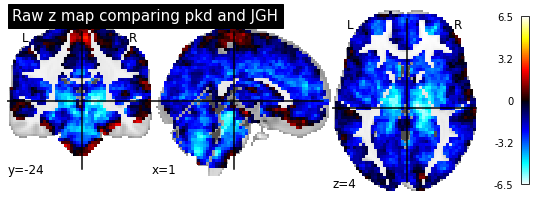

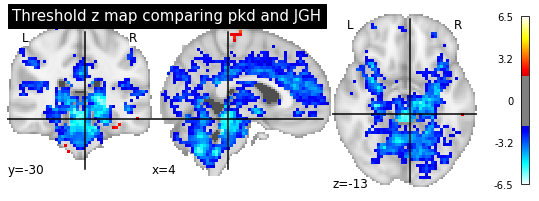

In [61]:
second_level_input = r2maps_pkd_jgh
second_level_model = SecondLevelModel().fit(
        second_level_input, design_matrix=design_matrix)

zmap_pkd_jgh = second_level_model.compute_contrast(
    'site', output_type='z_score')
plotting.plot_stat_map(zmap_pkd_jgh, title='Raw z map comparing pkd and JGH')
plotting.show()

plotting.plot_stat_map(zmap_pkd_jgh, threshold=2, title='Threshold z map comparing pkd and JGH')
plotting.show()

FDR, p<0.05 threshold: 2.539


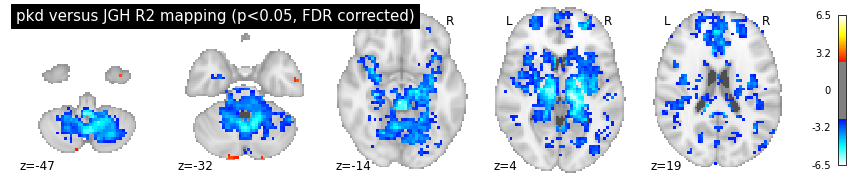

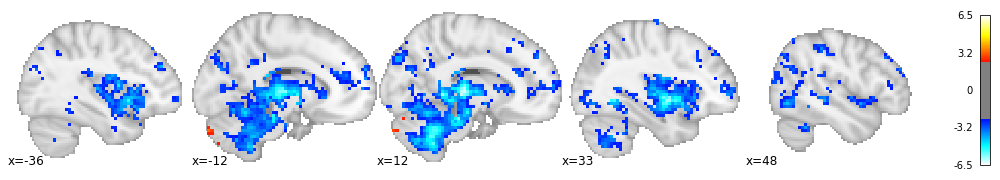

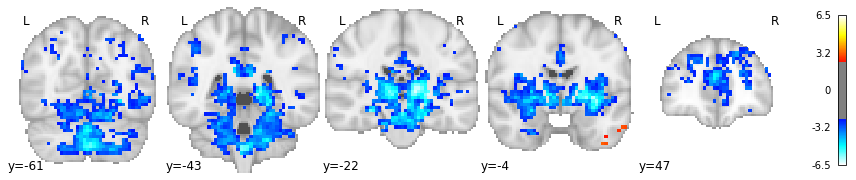

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)
0,1,57.0,-7.0,-29.0,3.695713,243
1,2,-12.0,-91.0,-35.0,3.384175,324
2,3,39.0,-4.0,-44.0,3.244783,108
3,4,51.0,-13.0,-26.0,3.152061,108
4,5,6.0,-28.0,76.0,3.106192,162
5,6,36.0,-1.0,-47.0,3.075148,27
6,7,60.0,-7.0,-26.0,3.065717,54
7,8,3.0,-19.0,73.0,3.012506,27
8,9,12.0,-91.0,-35.0,2.997659,81
9,10,51.0,29.0,-11.0,2.921565,27


In [62]:
_, threshold = map_threshold(zmap_pkd_jgh, alpha=.05, height_control='fdr')
print('FDR, p<0.05 threshold: %.3f' % threshold)
plotting.plot_stat_map(zmap_pkd_jgh, threshold=threshold, display_mode='z', cut_coords=5,
              title='pkd versus JGH R2 mapping (p<0.05, FDR corrected)')
plt.show()

plotting.plot_stat_map(zmap_pkd_jgh, threshold=threshold, display_mode='x', cut_coords=5)
plt.show()

plotting.plot_stat_map(zmap_pkd_jgh, threshold=threshold, display_mode='y', cut_coords=5)
plt.show()

get_clusters_table(zmap_pkd_jgh, stat_threshold=threshold, cluster_threshold=None)